# Telecom Customer Churn Prediction – ENSF 611 Final Project completed, Presented, and submitted by Peter Osaade.

This notebook implements an end-to-end machine learning workflow for predicting **customer churn** for a fictional telecom provider, **FlexTel Mobile**, using the **Telco Customer Churn** dataset originally from https://www.kaggle.com/datasets/blastchar/telco-customer-churn, but downloaded from https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv because of inconvenient Kaggle login and registration.


**Workflow overview:**

1. Load and inspect the dataset (WA_Fn-UseC_-Telco-Customer-Churn.csv) from the Kaggle link or the raw file from https://raw.githubusercontent.com/blastchar/telco-customer-churn/master/Telco-Customer-Churn.csv
2. Clean and preprocess the data
3. Build a reusable preprocessing pipeline  
4. Train and evaluate three models:
   - Logistic Regression (baseline)
   - Random Forest Classifier (non-linear)
   - SVM with RBF kernel (non-linear)
5. Run a **light `GridSearchCV`** on Random Forest  
6. Compare models and inspect feature importances


## 1. Imports and Global Configuration

In [20]:
# Import Relevant Libraries and Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay,
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Global config
CSV_FILE_NAME = 'Telco-Customer-Churn.csv'
RANDOM_SEED = 42
TEST_SIZE = 0.2

try:
    url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
    df = pd.read_csv(url)
except Exception as e:
    print("Falling back to local CSV:", e)
    df = pd.read_csv(CSV_FILE_NAME)


plt.rcParams['figure.figsize'] = (8, 5)
sns.set(style='whitegrid', rc={'axes.spines.right': False, 'axes.spines.top': False})

print('Imports complete.')


Imports complete.


## 2. Load and Clean the Dataset

In [21]:
# Load the Telco Customer Churn dataset
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
df = pd.read_csv(url)

print(f'Original shape: {df.shape}')
df.head()

Original shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [22]:
# Convert TotalCharges to numeric and drop rows where conversion fails
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print('Missing TotalCharges before drop:', df['TotalCharges'].isna().sum())

df = df.dropna(subset=['TotalCharges'])
print('Missing TotalCharges after drop:', df['TotalCharges'].isna().sum())
print('Shape after cleaning:', df.shape)


Missing TotalCharges before drop: 11
Missing TotalCharges after drop: 0
Shape after cleaning: (7032, 21)


## 3. Basic Exploratory Data Analysis (EDA)

In [23]:
# High-level info
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 
 17  

In [24]:
# Check class distribution for the target (Churn)
df['Churn'].value_counts()


,count
Churn,
No,5163
Yes,1869


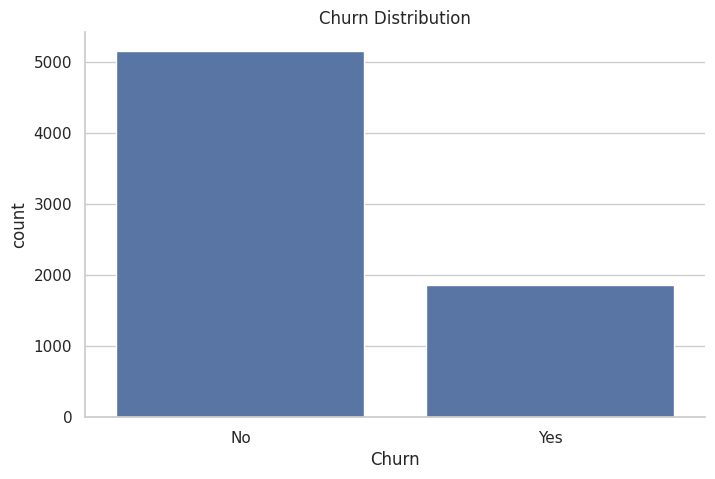

In [25]:
# Visualize churn distribution
sns.countplot(data=df, x='Churn')
plt.title('Churn Distribution')
plt.show()


In [26]:
# Quick look at some numerical features
df.describe()


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


## 4. Define Features, Target, and Preprocessing Pipeline

In [27]:
# Map target: 'Yes' -> 1, 'No' -> 0
y = df['Churn'].map({'No': 0, 'Yes': 1})
X = df.drop(columns=['Churn', 'customerID'])

# Identify categorical and numeric columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(exclude=['object']).columns.tolist()

print('Categorical columns:', categorical_cols)
print('Numeric columns:', numeric_cols)


Categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numeric columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


In [28]:
# Build ColumnTransformer for preprocessing
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, numeric_cols),
        ('categorical', categorical_transformer, categorical_cols),
    ]
)

print('Preprocessor ready.')


Preprocessor ready.


## 5. Train/Test Split

In [29]:
# Split Data into Training and Testing Sets.
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_SEED,
    stratify=y,
)

print(f'Train shape: {X_train.shape}')
print(f'Test shape : {X_test.shape}')


Train shape: (5625, 19)
Test shape : (1407, 19)


## 6. Define Model Pipelines

In [30]:
# Logistic Regression (baseline)
log_reg_pipeline = Pipeline(
    steps=[
        ('preprocess', preprocessor),
        ('model', LogisticRegression(max_iter=1000)),
    ]
)

# Random Forest (baseline)
rf_pipeline = Pipeline(
    steps=[
        ('preprocess', preprocessor),
        (
            'model',
            RandomForestClassifier(
                n_estimators=200,
                random_state=RANDOM_SEED,
                class_weight='balanced',
            ),
        ),
    ]
)

# SVM with RBF kernel
svm_pipeline = Pipeline(
    steps=[
        ('preprocess', preprocessor),
        (
            'model',
            SVC(
                kernel='rbf',
                probability=True,
                class_weight='balanced',
                random_state=RANDOM_SEED,
            ),
        ),
    ]
)

model_pipelines = {
    'Logistic Regression': log_reg_pipeline,
    'Random Forest (baseline)': rf_pipeline,
    'SVM (RBF)': svm_pipeline,
}

list(model_pipelines.keys())


['Logistic Regression', 'Random Forest (baseline)', 'SVM (RBF)']

## 7. Helper Function for Training and Evaluation

In [31]:
def evaluate_model(model_name, model_pipeline, X_train, X_test, y_train, y_test):
    """Fit pipeline, evaluate on test set, print metrics and return a dict of scores."""
    print(f"\n=== Training and evaluating: {model_name} ===")
    model_pipeline.fit(X_train, y_train)

    y_pred = model_pipeline.predict(X_test)
    y_proba = model_pipeline.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    print('Accuracy :', accuracy)
    print('Precision:', precision)
    print('Recall   :', recall)
    print('F1-score :', f1)
    print('ROC-AUC  :', roc_auc)

    print('\nClassification report:')
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['No Churn', 'Churn'],
        yticklabels=['No Churn', 'Churn'],
    )
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return {
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
    }

print('evaluate_model() helper defined.')


evaluate_model() helper defined.


## 8. Train and Evaluate Baseline Models


=== Training and evaluating: Logistic Regression ===
Accuracy : 0.8038379530916845
Precision: 0.6484848484848484
Recall   : 0.5721925133689839
F1-score : 0.6079545454545454
ROC-AUC  : 0.8359290473207676

Classification report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1033
           1       0.65      0.57      0.61       374

    accuracy                           0.80      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.80      0.80      1407



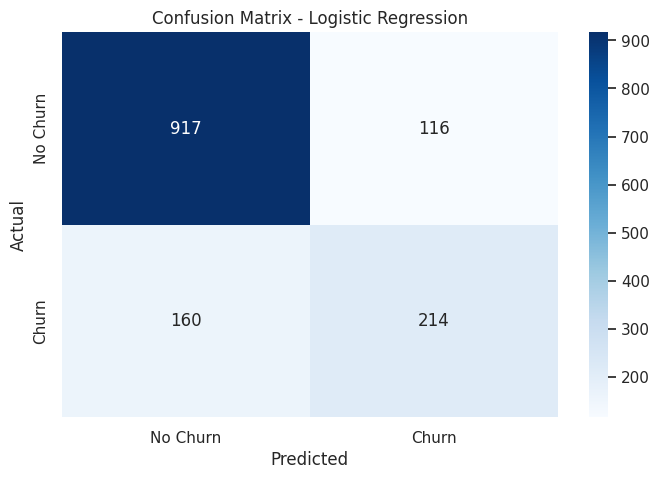


=== Training and evaluating: Random Forest (baseline) ===
Accuracy : 0.7839374555792467
Precision: 0.6232394366197183
Recall   : 0.4732620320855615
F1-score : 0.5379939209726444
ROC-AUC  : 0.8120395918642033

Classification report:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1033
           1       0.62      0.47      0.54       374

    accuracy                           0.78      1407
   macro avg       0.72      0.68      0.70      1407
weighted avg       0.77      0.78      0.77      1407



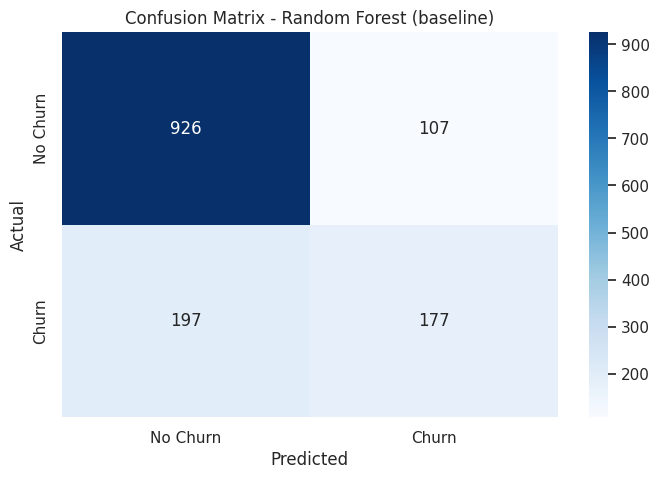


=== Training and evaluating: SVM (RBF) ===
Accuracy : 0.7256574271499645
Precision: 0.48986486486486486
Recall   : 0.7754010695187166
F1-score : 0.6004140786749482
ROC-AUC  : 0.8082566741384577

Classification report:
              precision    recall  f1-score   support

           0       0.90      0.71      0.79      1033
           1       0.49      0.78      0.60       374

    accuracy                           0.73      1407
   macro avg       0.69      0.74      0.70      1407
weighted avg       0.79      0.73      0.74      1407



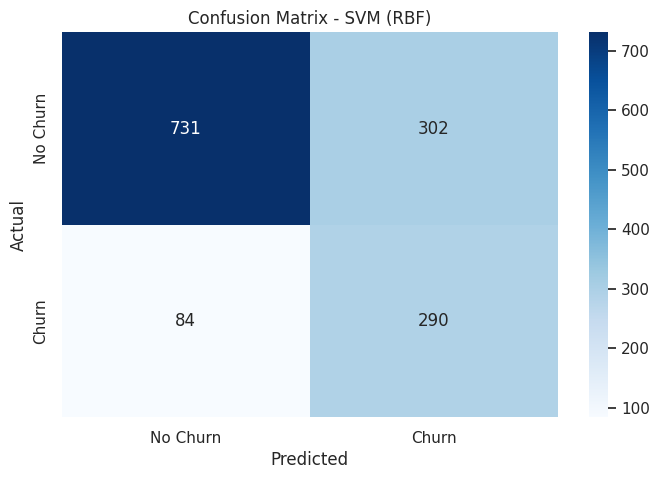

,model,accuracy,precision,recall,f1,roc_auc
0,Logistic Regression,0.803838,0.648485,0.572193,0.607955,0.835929
1,Random Forest (baseline),0.783937,0.623239,0.473262,0.537994,0.812040
2,SVM (RBF),0.725657,0.489865,0.775401,0.600414,0.808257


In [32]:
# The visualizations generated below are confusion matrices. The seaborn.heatmap function is used to create a graphical representation of
# these confusion matrices, which is why they look like heatmaps. So, while they are confusion matrices, they are displayed using a
# heatmap visualization to make the patterns of correct and incorrect predictions easier to see.


model_results = []

for model_name, model_pipeline in model_pipelines.items():
    result = evaluate_model(
        model_name=model_name,
        model_pipeline=model_pipeline,
        X_train=X_train,
        X_test=X_test,
        y_train=y_train,
        y_test=y_test,
    )
    model_results.append(result)

results_df = pd.DataFrame(model_results)
results_df


## 9. ROC Curves for All Baseline Models

<Figure size 800x500 with 0 Axes>

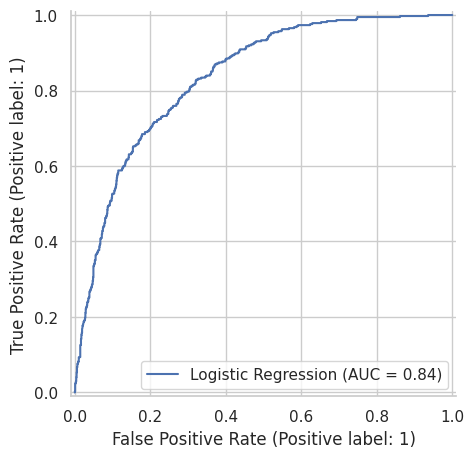

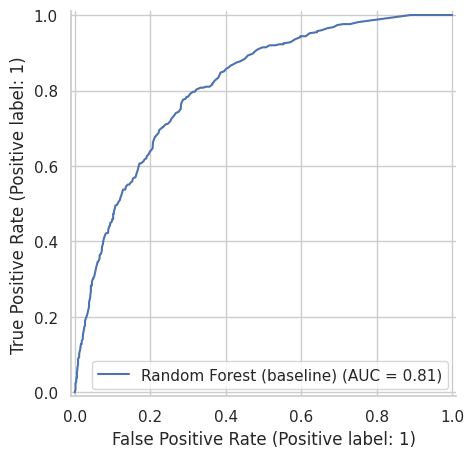

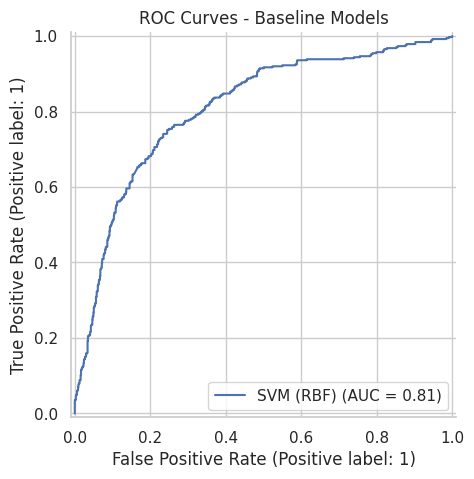

In [33]:
plt.figure()
for model_name, model_pipeline in model_pipelines.items():
    y_proba = model_pipeline.predict_proba(X_test)[:, 1]
    RocCurveDisplay.from_predictions(
        y_test,
        y_proba,
        name=model_name,
    )
plt.title('ROC Curves - Baseline Models')
plt.show()


## 10. Light GridSearchCV on Random Forest

In [34]:
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10],
    'model__min_samples_split': [2, 5],
}

rf_grid_search = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=1,
)

rf_grid_search.fit(X_train, y_train)

print('Best parameters:', rf_grid_search.best_params_)
print('Best ROC-AUC (CV):', rf_grid_search.best_score_)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters: {'model__max_depth': 10, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Best ROC-AUC (CV): 0.8436755603075342



=== Training and evaluating: Random Forest (tuned) ===
Accuracy : 0.7604832977967306
Precision: 0.5369261477045908
Recall   : 0.7192513368983957
F1-score : 0.6148571428571429
ROC-AUC  : 0.8307134611302939

Classification report:
              precision    recall  f1-score   support

           0       0.88      0.78      0.83      1033
           1       0.54      0.72      0.61       374

    accuracy                           0.76      1407
   macro avg       0.71      0.75      0.72      1407
weighted avg       0.79      0.76      0.77      1407



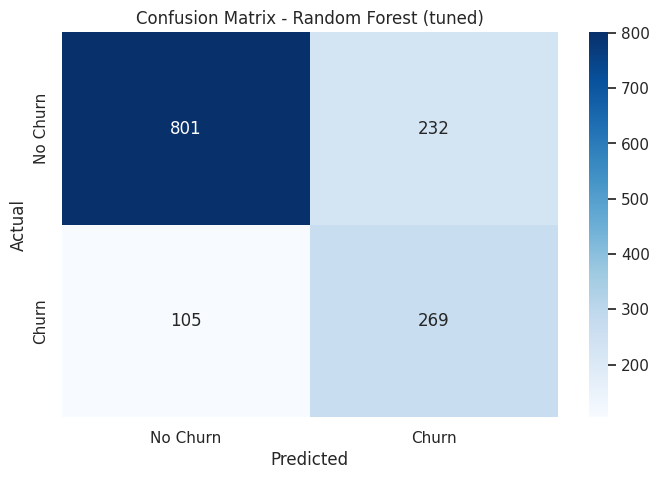

,model,accuracy,precision,recall,f1,roc_auc
0,Logistic Regression,0.803838,0.648485,0.572193,0.607955,0.835929
1,Random Forest (baseline),0.783937,0.623239,0.473262,0.537994,0.812040
2,SVM (RBF),0.725657,0.489865,0.775401,0.600414,0.808257
3,Random Forest (tuned),0.760483,0.536926,0.719251,0.614857,0.830713


In [35]:
rf_tuned_pipeline = rf_grid_search.best_estimator_
rf_tuned_result = evaluate_model(
    model_name='Random Forest (tuned)',
    model_pipeline=rf_tuned_pipeline,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
)

results_df = pd.concat([results_df, pd.DataFrame([rf_tuned_result])], ignore_index=True)
results_df


## 11. Feature Importances from Tuned Random Forest

In [36]:
# Extract feature names after preprocessing
ohe = rf_tuned_pipeline.named_steps['preprocess'].named_transformers_['categorical']
encoded_cat_features = ohe.get_feature_names_out(categorical_cols)
all_feature_names = np.concatenate([numeric_cols, encoded_cat_features])

rf_tuned_model = rf_tuned_pipeline.named_steps['model']
importances = rf_tuned_model.feature_importances_

feature_importances = pd.DataFrame(
    {'feature': all_feature_names, 'importance': importances}
).sort_values(by='importance', ascending=False)

feature_importances.head(15)


,feature,importance
1,tenure,0.126688
36,Contract_Month-to-month,0.123807
3,TotalCharges,0.102966
2,MonthlyCharges,0.077264
38,Contract_Two year,0.064150
18,OnlineSecurity_No,0.056058
27,TechSupport_No,0.045996
16,InternetService_Fiber optic,0.042151
43,PaymentMethod_Electronic check,0.035963
37,Contract_One year,0.018754


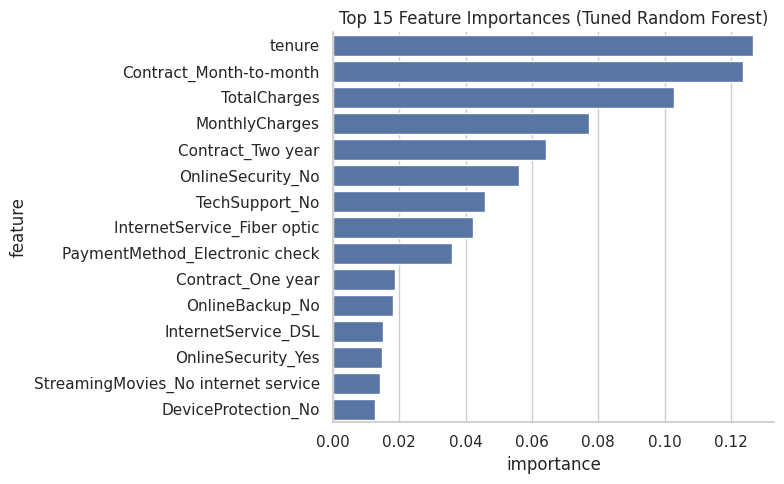

In [37]:
sns.barplot(
    data=feature_importances.head(15),
    x='importance',
    y='feature',
)
plt.title('Top 15 Feature Importances (Tuned Random Forest)')
plt.tight_layout()
plt.show()


## 12. Save Results

In [38]:
results_df.to_csv('model_comparison_results.csv', index=False)
feature_importances.to_csv('feature_importances_tuned_rf.csv', index=False)
print('Saved model_comparison_results.csv and feature_importances_tuned_rf.csv')


Saved model_comparison_results.csv and feature_importances_tuned_rf.csv


## 13. Conclusion

In this project, I:

- Loaded and cleaned the **Telco Customer Churn** dataset  
- Built a **preprocessing pipeline** using `ColumnTransformer` for numeric + categorical features  
- Trained and evaluated three models:
  - Logistic Regression  
  - Random Forest (baseline and tuned with a light `GridSearchCV`)  
  - SVM with RBF kernel  
- Compared performance using accuracy, precision, recall, F1-score, and ROC-AUC  
- Visualized performance with confusion matrices and ROC curves  
- Inspected feature importances to understand which factors drive churn the most.